In [36]:
import math
import numpy as np
import pandas as pd
import seaborn as sns

def generate_adjacency_matrix(N):
    # n_genes = 10
    a = np.random.randint(0, 3, (N, N))
    a[np.tril_indices(a.shape[0], -1)] = a.T[np.tril_indices(a.shape[0], -1)]
    b = np.fliplr(a)
    b[np.tril_indices(b.shape[0], -1)] = b.T[np.tril_indices(a.shape[0], -1)]

    b[b == 2] = -1
    np.fill_diagonal(b, 0)  # Remove self loops
    return b

def get_vector_that_provides_corr(rho, x1):
    n = x1.shape[0]  # length of vector, the number of samples for the same gene that we define in n_cols
    # ho = 0.6  # desired correlation = cos(angle)
    theta = math.acos(rho)  # corresponding angle
    x2 = np.random.normal(2, 0.5, n)  # new random data
    X = np.c_[x1, x2]  # matrix
    Xctr = pd.DataFrame(X).apply(lambda x: x - x.mean()).to_numpy()  # centered columns (mean 0)
    Id = np.diag(np.repeat(1, n))  # identity matrix
    Q = np.linalg.qr(Xctr[:, 0].reshape(n, 1))[0].flatten()  # QR-decomposition, just matrix Q
    P = np.outer(Q, Q)  # projection onto space defined by x1
    x2o = np.dot((Id - P), Xctr[:, 1])  # x2ctr made orthogonal to x1ctr
    Xc2 = np.c_[Xctr[:, 0], x2o]  # bind to matrix
    Y = np.dot(Xc2, np.diag(1 / np.sqrt(np.sum(np.power(Xc2, 2), axis=0))))  # scale columns to length 1
    x = Y[:, 1] + (1 / np.tan(theta)) * Y[:, 0]
    x_norm = (x - x.mean()) / (x.std())
    return x_norm


def simulate_expression_from_adjacency(adjamat, n_samples=100, simdata_noise=0.1):
    # noise = 0.5 # .1 strong correlation, 3 weak correlation
    # random initialize data matrix
    # n_samples = 40 # number of samples: 40 so we later split into 20 cases and 20 controls
    n_rows = adjamat.shape[0]  # number of genes
    mu, sigma = 1, 1  # mean and standard deviation
    dataset = np.random.normal(mu, sigma, n_samples * n_rows).reshape(n_rows, n_samples)
    already_modified = np.repeat(0, n_rows)  # N=n1+n2 genes
    already_modified[0] = 1  # leave the first gene alone, base case

    for i in range(adjamat.shape[1]):
        for j in range(i + 1, adjamat.shape[1]):
            # print(f'Considering row: {i}, column: {j} of A')
            if (adjamat[i, j] == 1) & (already_modified[j] == 0):
                # print(i,j)
                # print(A[i,j])
                dataset[j, :] = dataset[i, :] +  np.random.normal(0, simdata_noise, dataset.shape[1])
                already_modified[j] = 1
            elif (adjamat[i, j] == -1) & (already_modified[j] == 0):
                # print(i,j)
                # print(A[i,j])
                dataset[j, :] = -dataset[i, :] + np.random.normal(0, simdata_noise, dataset.shape[1])
                already_modified[j] = 1
            elif (already_modified[j] == 1) & (already_modified[i] == 0):
                #if j is  modified, we accordingly modify i. If i has been modified, we do nothing.
                dataset[i,:] = dataset[j,:] + np.random.normal(0, noise, dataset.shape[1])
                already_modified[i] = 1
    ds = pd.DataFrame(dataset)
    ds.columns = 'sample_' + ds.columns.astype(str)
    ds.index = 'gene_' + ds.index.astype(str)
    return ds

def ground_truth_from_adjamat(adjamat):
    genenames = ['gene_' + s for s in list(str(i) for i in range(n_genes))]

    gene_A = []
    gene_B = []
    rels = []
    for i in range(adjamat.shape[1]):
        for j in range(i + 1, adjamat.shape[1]):
            if adjamat[i][j] != 0:
                #print(i, j, adjamat[i, j])
                gene_A.append(i)
                gene_B.append(j)
                rels.append(np.where(adjamat[i, j] > 0, "[+]", "[-]"))

    pairs = pd.DataFrame({'gene_A': gene_A, 'gene_B': gene_B, 'correlation': rels})
    mygenedict = dict(zip(range(adjamat.shape[1]), genenames))
    pairs.gene_A = pairs.gene_A.map(mygenedict)
    pairs.gene_B = pairs.gene_B.map(mygenedict)
    return pairs

[[ 0  1  0 -1  1]
 [ 1  0  1  1 -1]
 [ 0  1  0  1  0]
 [-1  1  1  0  1]
 [ 1 -1  0  1  0]]
        sample_0  sample_1  sample_2  sample_3  sample_4  sample_5  sample_6  \
gene_0  0.320005  0.921133  0.075221 -0.537335  1.173093  0.245979  0.836458   
gene_1  1.111054 -0.240331 -0.363439  0.071534  1.003835  1.823750  0.373152   
gene_2  1.305643 -0.013145 -1.083192  0.437532  1.448827  0.945740  0.223769   
gene_3 -2.106391 -0.127949 -1.371708  0.298765 -1.368762 -0.130453  0.167736   
gene_4  0.433421  2.334904 -0.660399 -0.550654  0.273211  1.361355  1.156061   

        sample_7  sample_8  sample_9  ...  sample_40  sample_41  sample_42  \
gene_0  1.246818 -0.308439  2.407880  ...   0.387203   1.367454   2.190392   
gene_1 -0.175146  0.276175  3.143983  ...   0.565697   2.082885   1.888980   
gene_2 -0.173303  0.929935  2.354171  ...   0.264990   0.886275   2.323589   
gene_3 -1.946284 -1.390924 -0.543058  ...   1.075741  -1.615698  -2.024637   
gene_4  0.027120 -0.862065  1.120548  

<AxesSubplot:>

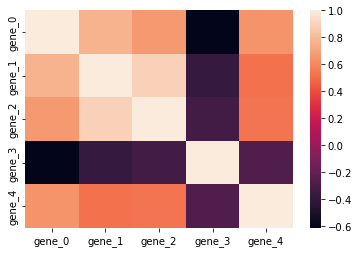

In [48]:
n_genes = 5
adjamat = generate_adjacency_matrix(N=n_genes)
print(adjamat)
ds = simulate_expression_from_adjacency(adjamat=adjamat, n_samples=50, simdata_noise=0.8)
groundtruth = ground_truth_from_adjamat(adjamat)
#ds.to_csv('dataset_'+ str(n_genes) + '.csv')
print(ds)
print(groundtruth)
sns.heatmap(ds.T.corr())